# New structure processing

In [ ]:
!pip install bio

In [ ]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBList, PDBIO, Select
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Loading tables with atoms

In [ ]:
struct_id = '1an1'
Atoms_coord_df = pd.read_csv(f'1an1.csv')
Atoms_coord_df

Chain_name  Chain_num Residue Type       x       y      z
0             E          0     ILE    N  26.110  53.699  7.022
1             E          0     ILE   CA  26.623  55.061  6.700
2             E          0     ILE    C  27.969  54.893  5.987
3             E          0     ILE    O  28.861  54.230  6.514
4             E          0     ILE   CB  26.849  55.912  7.980
...         ...        ...     ...  ...     ...     ...    ...
1910          I          1     PRO    C  23.560  28.506  4.216
1911          I          1     PRO    O  23.658  28.321  2.978
1912          I          1     PRO   CB  21.198  28.283  5.133
1913          I          1     PRO   CG  20.422  28.147  3.837
1914          I          1     PRO   CD  20.370  29.574  3.349

[1915 rows x 7 columns]

## Finding the separating plane using logistic regression method

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(Atoms_coord_df[['x', 'y', 'z']].values, Atoms_coord_df['Chain_num'].astype('int'))

# plane_bind - coefficient list [A,B,C,D] in the separating plane equation of the form A*x+B*y+C*z+D=0
plane_bind = list(logreg_clf.coef_[0])
plane_bind.append(logreg_clf.intercept_[0])
print(plane_bind)

[-0.04499577372343709, -0.4966247095253128, -0.3489440338861201, 24.31630317978242]


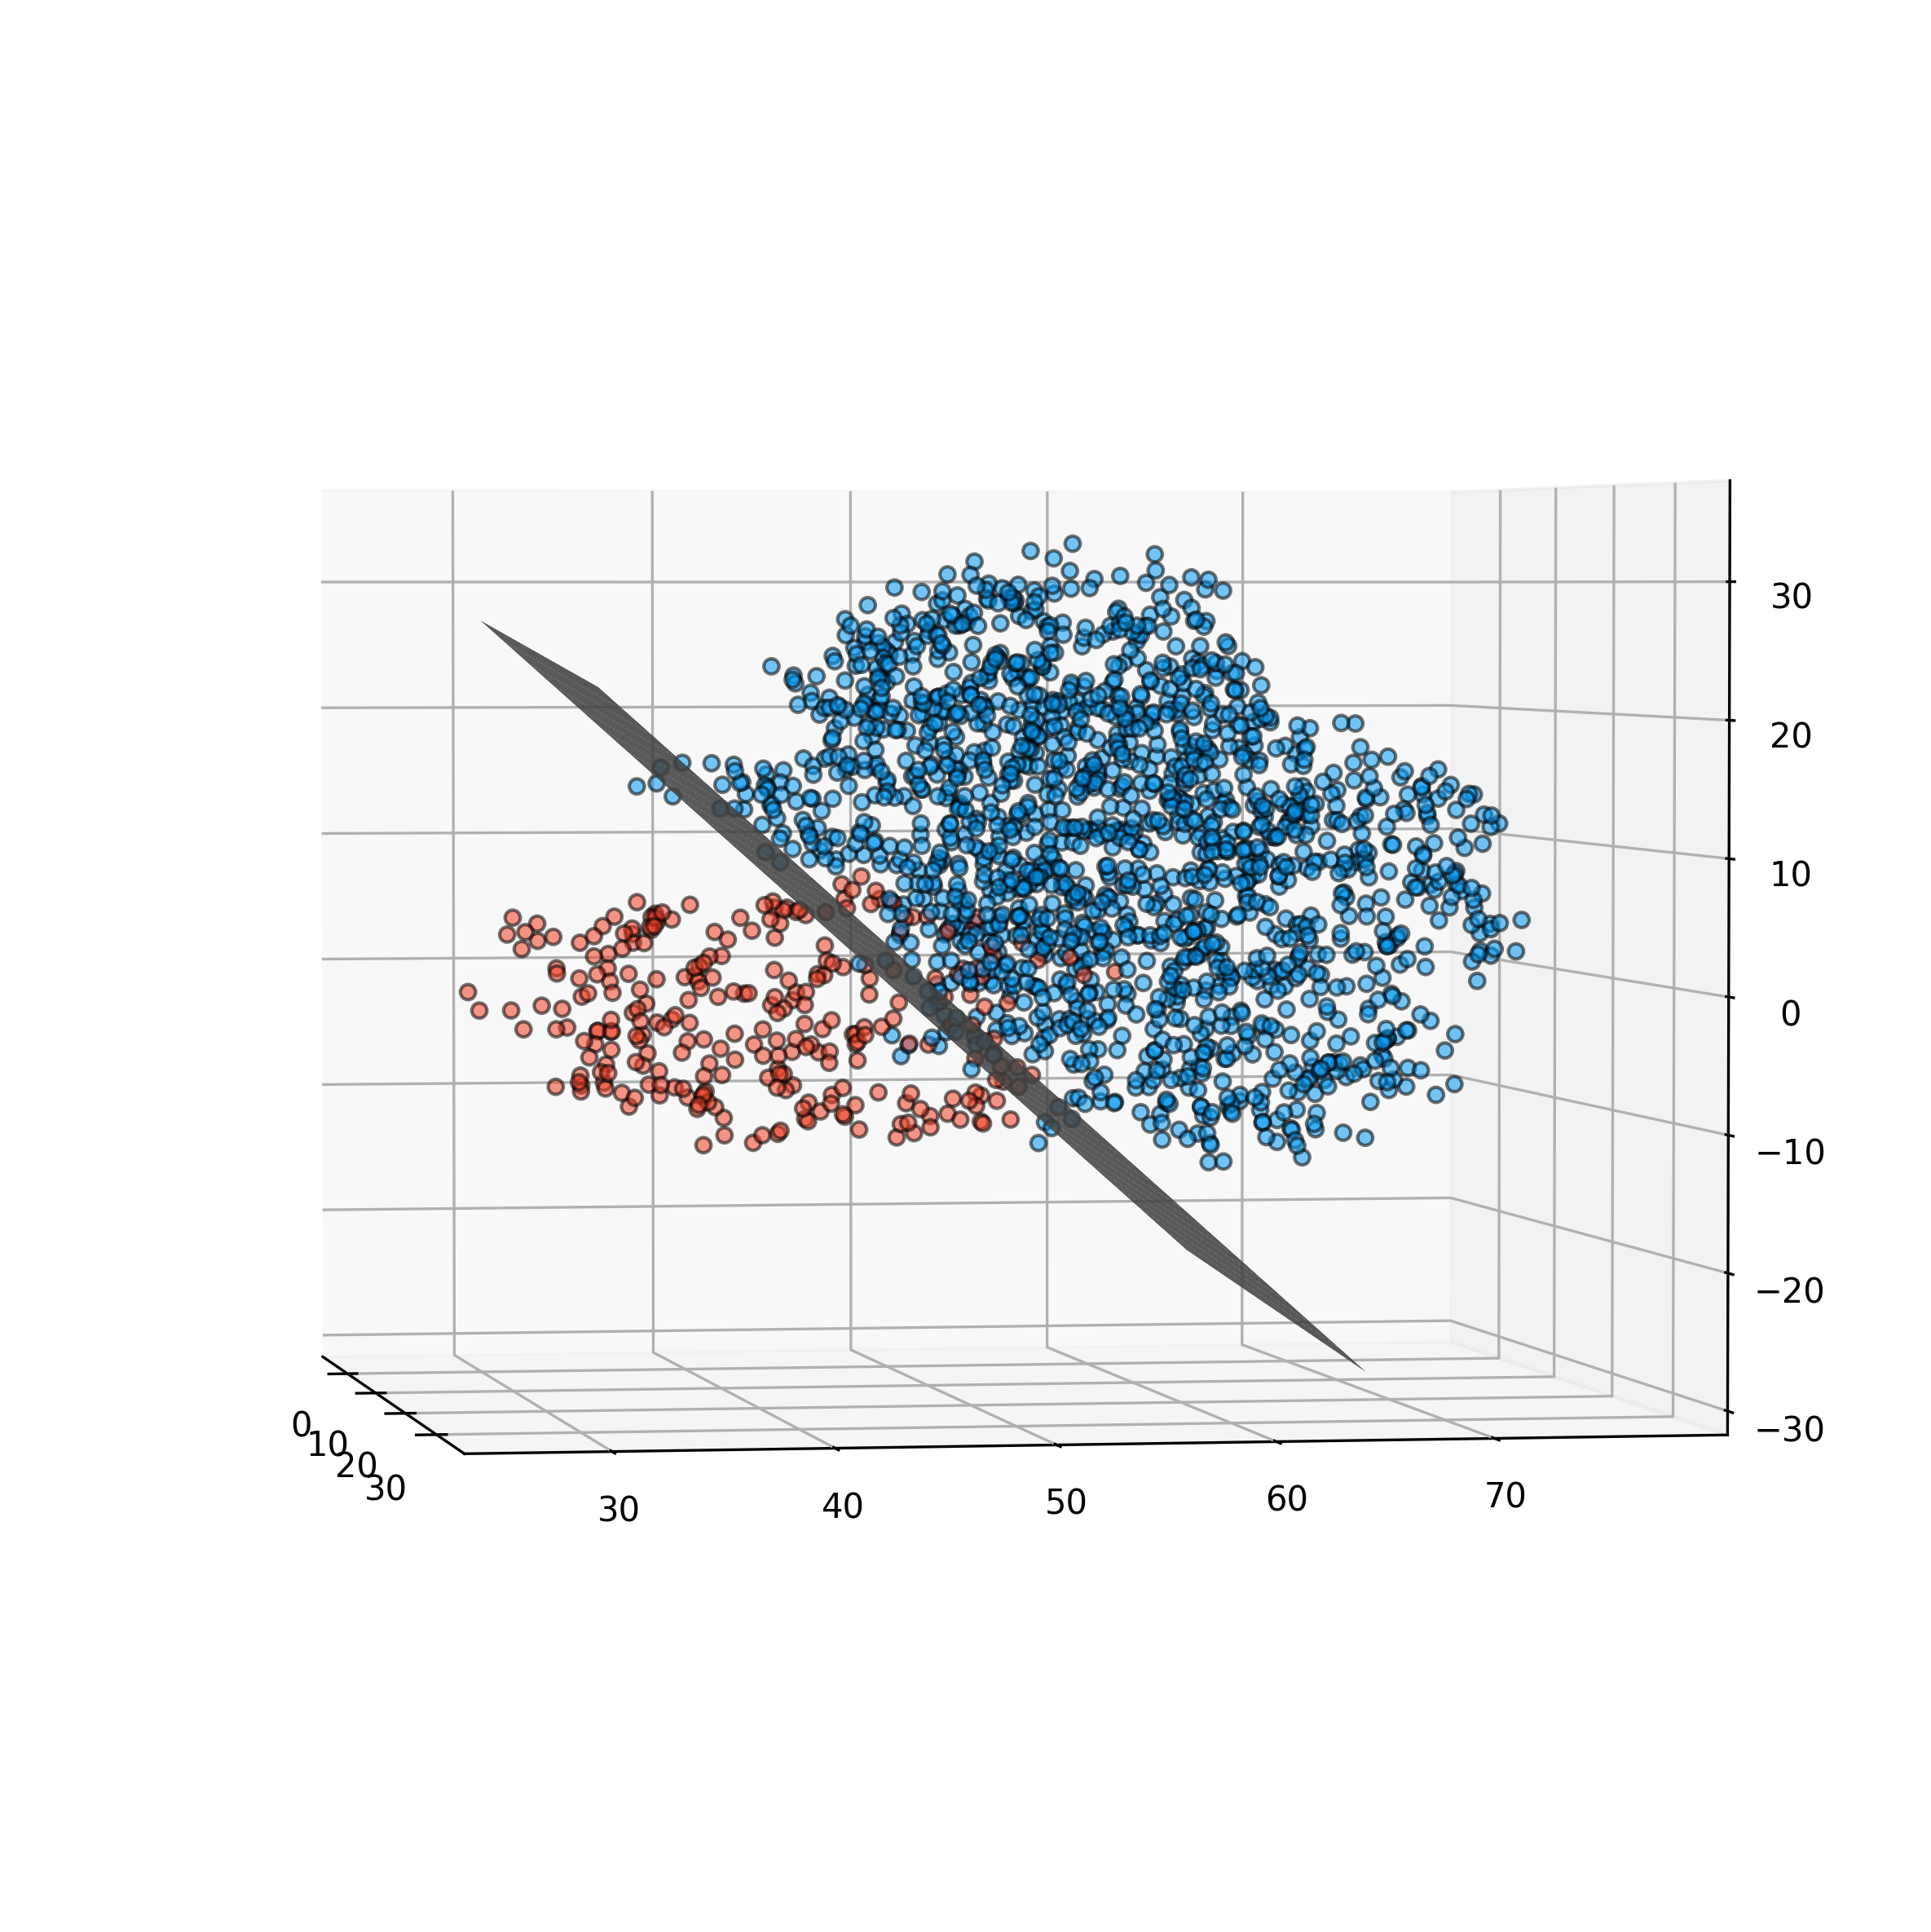

In [ ]:
z = lambda x,y: (-logreg_clf.intercept_[0]-logreg_clf.coef_[0][0]*x-logreg_clf.coef_[0][1]*y) / logreg_clf.coef_[0][2]


tmp_y = np.linspace(30, 65, 30)
tmp_x = np.linspace(0, 35, 30)

x,y = np.meshgrid(tmp_x,tmp_y)

fig = plt.figure(figsize=(16, 10), dpi=300)
ax = plt.axes(projection="3d")
ax.plot_surface(x, y, z(x,y), color='grey')

chain_list = list(map(int, Atoms_coord_df['Chain_num'].values))
colors = np.array(["#069AF3", "#EF4026"])
ax.scatter3D(Atoms_coord_df['x'], Atoms_coord_df['y'], Atoms_coord_df['z'], c=colors[chain_list], edgecolors='black', s=20, alpha=0.55)

ax.view_init(2, -10)
plt.show()
fig.savefig('sep_plane.png', bbox_inches = 'tight')

## Search for the centers of mass of molecules near the interface and search for the direction of greatest extent

In [ ]:
from math import sqrt
#Function for finding points with the greatest distance
def dist(p1, p2):
  x0 = p1[0] - p2[0]
  y0 = p1[1] - p2[1]
  z0 = p1[2] - p2[2]
  return x0 * x0 + y0 * y0 + z0 * z0


def maxDist(p):
  n = p.shape[0]
  maxm = 0
  for i in range(n):
    for j in range(i + 1, n):
      #print(dist(p.iloc[i], p.iloc[j]))
      if dist(p.iloc[i], p.iloc[j]) > maxm:
       maxm = dist(p.iloc[i], p.iloc[j])
       max_1 = i
       max_2 = j

  return [max_1, max_2, sqrt(maxm)]

Determining the offset for planes parallel to the dividing line at a distance of 10

In [ ]:
distant=10
abs_d = distant*(np.sqrt(plane_bind[0]**2+plane_bind[1]**2+plane_bind[2]**2))
print(abs_d)
coeff_up = -abs_d + plane_bind[3]
coeff_down = abs_d + plane_bind[3]
#print(D_up, D_down)

6.0862357869933845


In [ ]:
# limiting the area for searching for centers of mass
plane_20_1=[plane_bind[0], plane_bind[1], plane_bind[2], coeff_down]
plane_20_2=[plane_bind[0], plane_bind[1], plane_bind[2], coeff_up]
# Obtaining centers of mass for proteins
center_1=[]
x1=0
y1=0
z1=0
k1=0
center_2=[]
x2=0
y2=0
z2=0
k2=0

Atoms_3A_1 = pd.DataFrame(columns=['Num', 'x', 'y', 'z', 'd', 'Chain'])
Atoms_3A_2 = pd.DataFrame(columns=['Num', 'x', 'y', 'z', 'd', 'Chain'])
Atoms_coord = pd.DataFrame(columns=['Num', 'x', 'y', 'z', 'Chain'])
for j in range(Atoms_coord_df.shape[0]):
    # substitute the coordinates into the equation of the boundary planes, and select points inside the area limited by them
    d_down = plane_20_1[0]*Atoms_coord_df['x'][j] + plane_20_1[1]*Atoms_coord_df['y'][j] + plane_20_1[2]*Atoms_coord_df['z'][j] + plane_20_1[3]
    d_up = plane_20_2[0]*Atoms_coord_df['x'][j] + plane_20_2[1]*Atoms_coord_df['y'][j] + plane_20_2[2]*Atoms_coord_df['z'][j] + plane_20_2[3]
    if abs(d_down)<1:
        Atoms_3A_1.loc[len(Atoms_3A_1.index)] = [j, Atoms_coord_df['x'][j], Atoms_coord_df['y'][j], Atoms_coord_df['z'][j], d_down, int(Atoms_coord_df['Chain_num'][j])]
    if abs(d_up)<1:
            Atoms_3A_2.loc[len(Atoms_3A_2.index)] = [j,Atoms_coord_df['x'][j], Atoms_coord_df['y'][j], Atoms_coord_df['z'][j], d_up, int(Atoms_coord_df['Chain_num'][j])]
    if d_down >=0 and d_up <=0:
        Atoms_coord.loc[len(Atoms_coord.index)] = [j, Atoms_coord_df['x'][j], Atoms_coord_df['y'][j], Atoms_coord_df['z'][j], int(Atoms_coord_df['Chain_num'][j])]
        if Atoms_coord_df['Chain_num'][j]==0:
            x1+=Atoms_coord_df['x'][j]
            y1+=Atoms_coord_df['y'][j]
            z1+=Atoms_coord_df['z'][j]
            k1+=1
        elif Atoms_coord_df['Chain_num'][j]==1:
            x2+=Atoms_coord_df['x'][j]
            y2+=Atoms_coord_df['y'][j]
            z2+=Atoms_coord_df['z'][j]
            k2+=1
center_1=[round(x1/k1), round(y1/k1), round(z1/k1)]
center_2=[round(x2/k2), round(y2/k2), round(z2/k2)]
if Atoms_3A_2.shape[0]>=Atoms_3A_1.shape[0]:
    Atoms_3A = Atoms_3A_2
else:
    Atoms_3A = Atoms_3A_1

if Atoms_3A.shape[0] < 2:
    with open("Dataset/Diff_struct.csv", mode="a", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter = ",")
        file_writer.writerow([str_num, struct_id])
#    continue
dots_max_dist = maxDist(Atoms_3A[['x', 'y', 'z']])

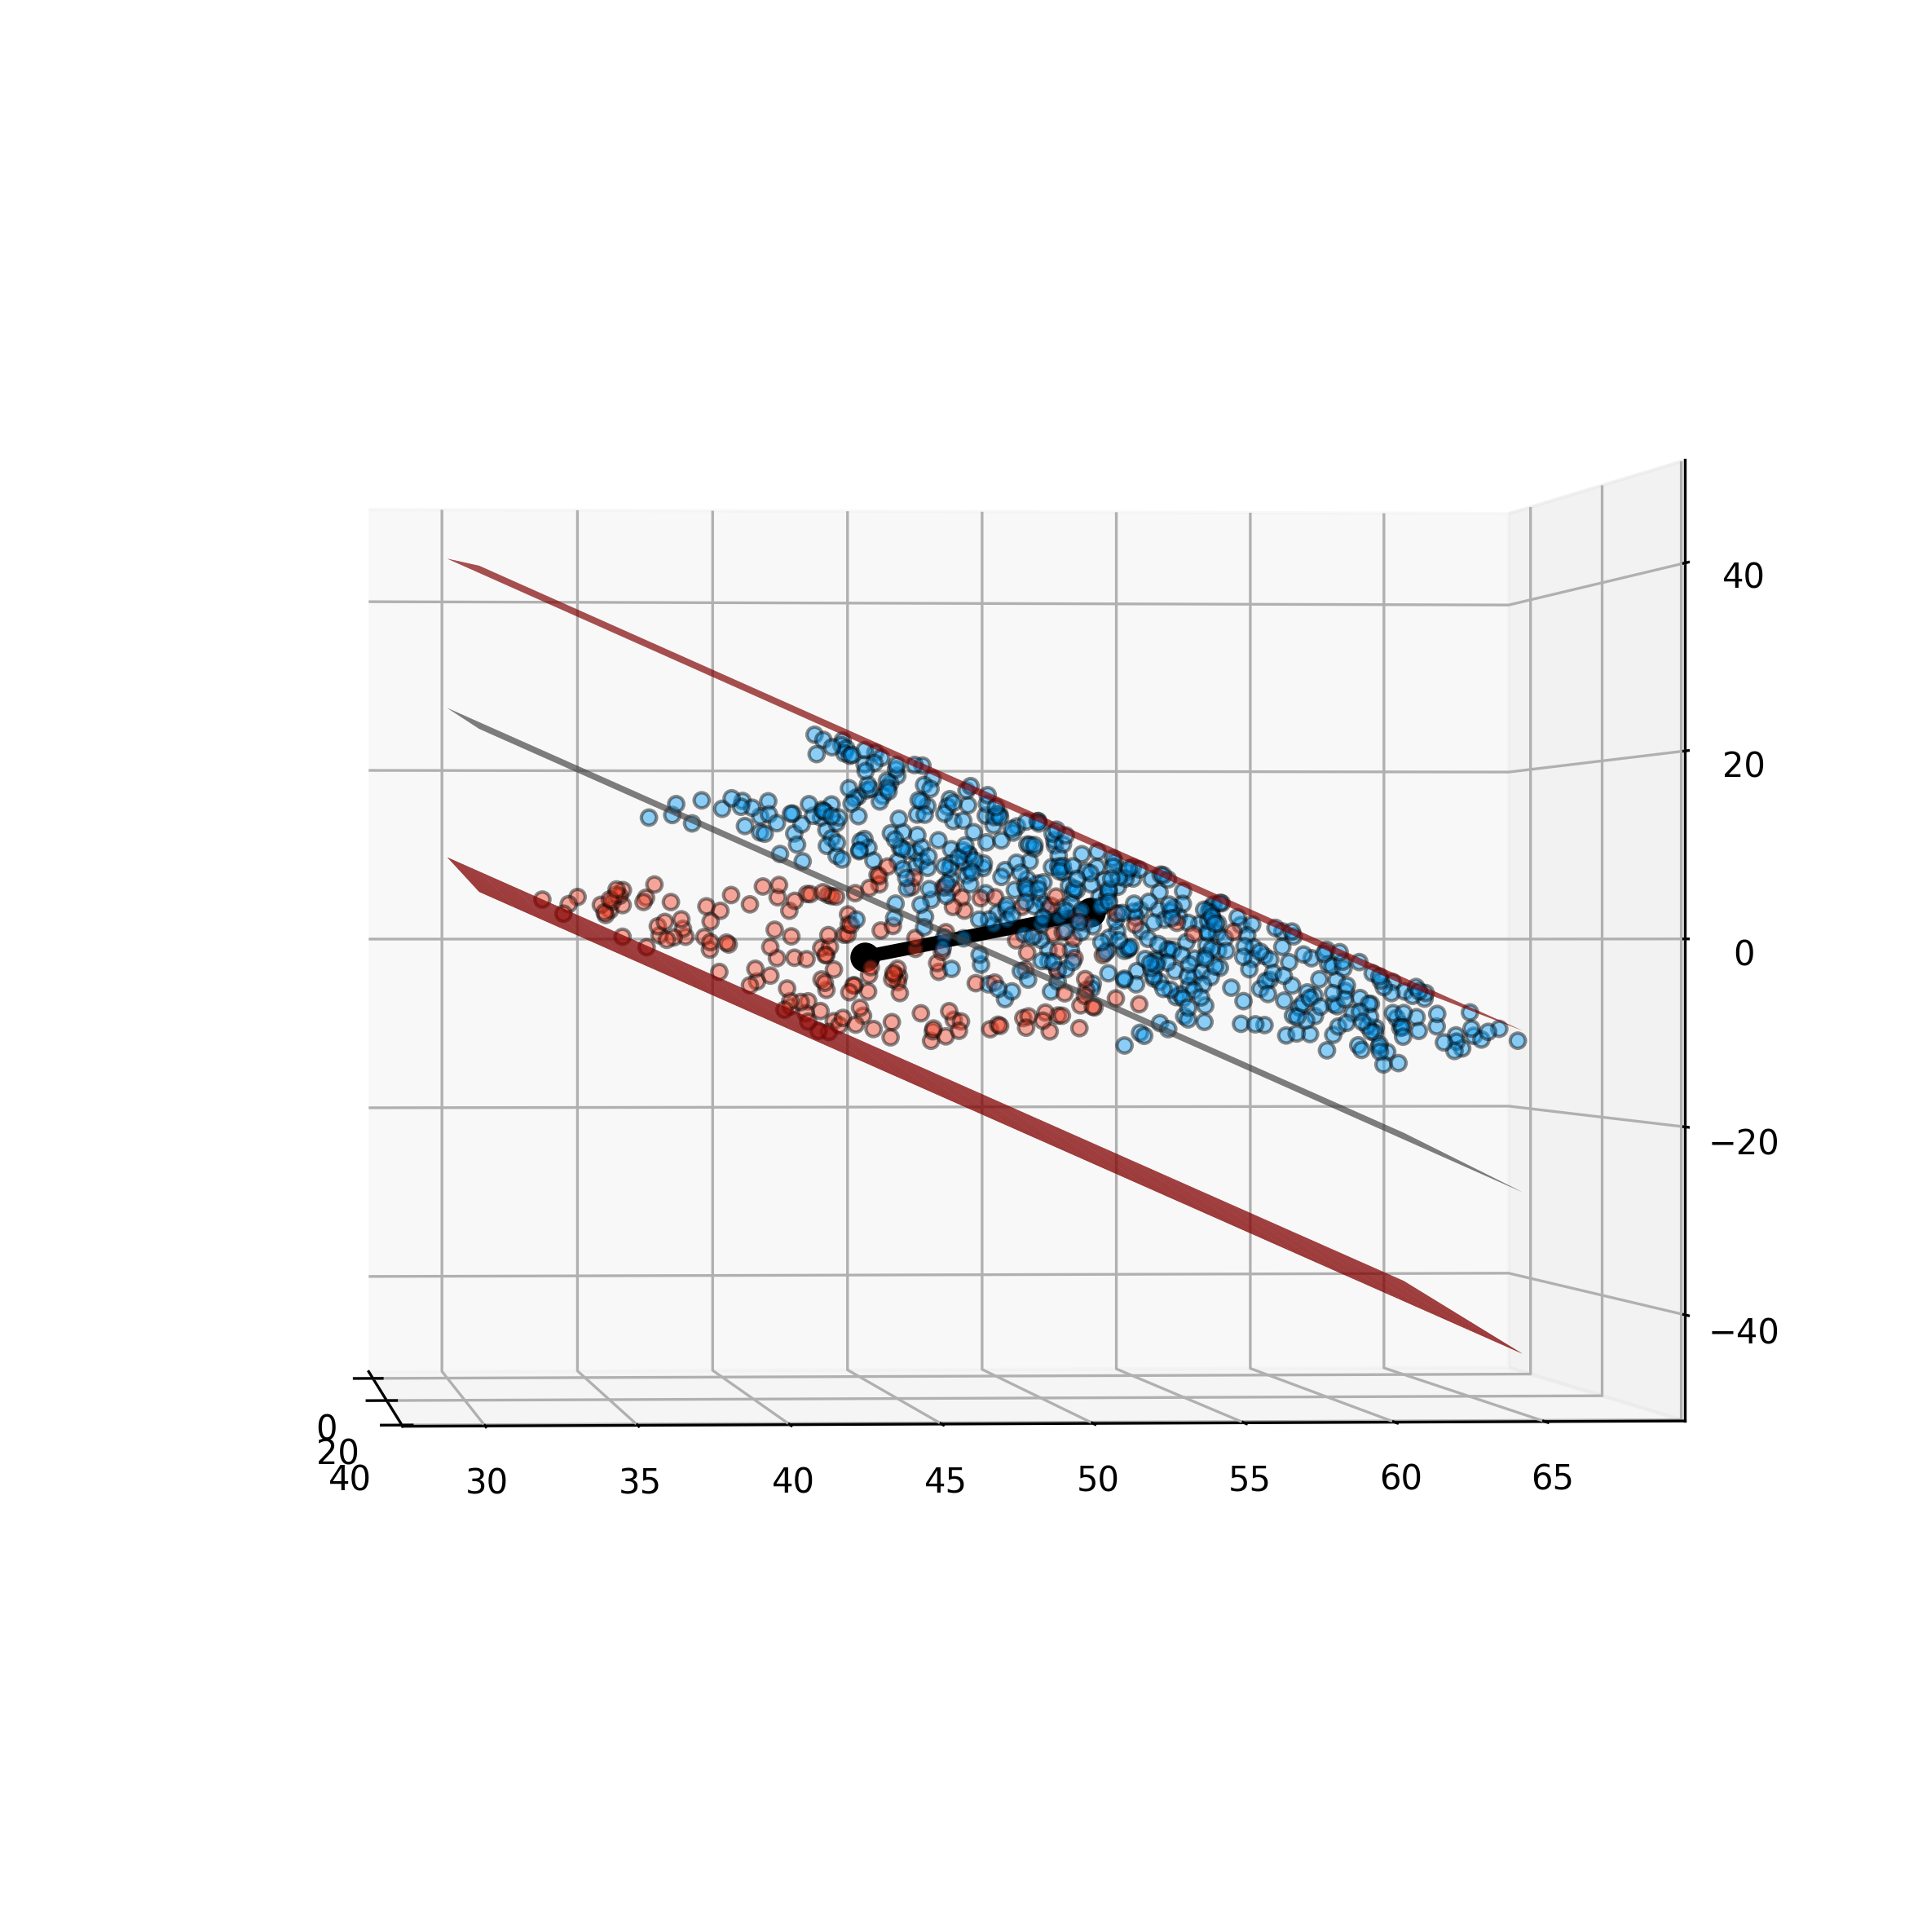

In [ ]:
z = lambda x,y: (-plane_bind[3]-plane_bind[0]*x-plane_bind[1]*y) / plane_bind[2]
z_1 = lambda x,y: (-plane_20_1[3]-plane_20_1[0]*x-plane_20_1[1]*y) / plane_20_1[2]
z_2 = lambda x,y: (-plane_20_2[3]-plane_20_2[0]*x-plane_20_2[1]*y) / plane_20_2[2]
tmp_y = np.linspace(30, 65, 60)
tmp_x = np.linspace(0, 35, 40)

fig = plt.figure(figsize=(16, 10), dpi=300)
ax = plt.axes(projection="3d")
x,y = np.meshgrid(tmp_x,tmp_y)


ax.plot_surface(x, y, z(x,y), color='grey', label = 'Separating plane')
ax.plot_surface(x, y, z_1(x,y), color='red', label = 'Bottom limit')
ax.plot_surface(x, y, z_2(x,y), color='red', label = 'Upper limit')

chain_list = list(map(int, Atoms_coord['Chain'].values))

ax.plot3D([center_1[0],center_2[0]], [center_1[1],center_2[1]], [center_1[2],center_2[2]], 'black', linewidth= 4)
colors = np.array(["#069AF3", "#EF4026"])
ax.scatter3D(Atoms_coord['x'], Atoms_coord['y'], Atoms_coord['z'], c=colors[chain_list], edgecolors='black', s=20, alpha=0.45)
ax.scatter3D(center_1[0], center_1[1], center_1[2], c = 'k', edgecolors='black', s=60, alpha=1)
ax.scatter3D(center_2[0], center_2[1], center_2[2], c = 'k', edgecolors='black', s=60, alpha=1)


ax.view_init(0, -5)
#plt.legend()
plt.xticks(np.arange(0, 45, step=20))
plt.show()

fig.savefig('mass_centers.png', bbox_inches = 'tight')


## Determination of vectors of a new basis and transition to it

Finding the intersection of the vector connecting the centers of mass with the dividing plane. The resulting point will be the center of the cell.

In [ ]:
# Function for finding the intersection point of a vector with a plane
def add_v3v3(v0, v1):
    return (
        v0[0] + v1[0],
        v0[1] + v1[1],
        v0[2] + v1[2],
    )


def sub_v3v3(v0, v1):
    return (
        v0[0] - v1[0],
        v0[1] - v1[1],
        v0[2] - v1[2],
    )


def dot_v3v3(v0, v1):
    return (
        (v0[0] * v1[0]) +
        (v0[1] * v1[1]) +
        (v0[2] * v1[2])
    )


def len_squared_v3(v0):
    return dot_v3v3(v0, v0)


def mul_v3_fl(v0, f):
    return (
        v0[0] * f,
        v0[1] * f,
        v0[2] * f,
    )

def isect_line_plane_v3_4d(p0, p1, plane, epsilon=1e-6):
    u = sub_v3v3(p1, p0)
    dot = dot_v3v3(plane, u)

    if abs(dot) > epsilon:
        # Calculate a point on the plane
        # (divide can be omitted for unit hessian-normal form).
        p_co = mul_v3_fl(plane, -plane[3] / len_squared_v3(plane))

        w = sub_v3v3(p0, p_co)
        fac = -dot_v3v3(plane, w) / dot
        u = mul_v3_fl(u, fac)
        return add_v3v3(p0, u)

    return None

In [ ]:
#dot_is - coordinates of the intersection point, and therefore the cell center
dot_is = isect_line_plane_v3_4d(center_1, center_2, plane_bind)
dot_is

(17.585246717255973, 47.31802626195221, 0.0737664137201346)

In [ ]:
x0, y0, z0 = dot_is[0], dot_is[1], dot_is[2]
x1, y1, z1 = center_1[0], center_1[1], center_1[2]
x2, y2, z2 = center_2[0], center_2[1], center_2[2]
n_v = [(x1 - x0), (y1 - y0), (z1 - z0)]

In [ ]:
#vector connecting points with the greatest distance
vec_3 = [[Atoms_3A['x'][dots_max_dist[0]] - Atoms_3A['x'][dots_max_dist[1]], Atoms_3A['y'][dots_max_dist[0]] - Atoms_3A['y'][dots_max_dist[1]], Atoms_3A['z'][dots_max_dist[0]] - Atoms_3A['z'][dots_max_dist[1]]]]

# Obtaining the projection of the vector vec_5 onto the dividing plane
# vector u
u = np.array(vec_3)

# vector n: n is orthogonal vector to Plane P
n = np.array([plane_bind[0], plane_bind[1], plane_bind[2]])

# Task: Project vector u on Plane P

# finding norm of the vector n
n_norm = np.sqrt(sum(n**2))

# Apply the formula as mentioned above
# for projecting a vector onto the orthogonal vector n
# find dot product using np.dot()
proj_of_u_on_n = (np.dot(u, n)/n_norm**2)*n
proj_vec = u - proj_of_u_on_n
proj_vec = np.reshape(proj_vec, -1)

norm = plane_bind[:3]
a = sqrt(1/sum([coor**2 for coor in norm]))
norm = [a*coor for coor in norm]
norm = np.array(norm)
a = sqrt(1/sum([coor**2 for coor in proj_vec]))
proj_vec = a*proj_vec
last_vector = np.cross(norm, proj_vec)

In [ ]:
from math import radians, sin, cos

def rotate_point_wrt_center(point_to_be_rotated, angle, center_point = (0,0)):

    angle = radians(angle)

    xnew = cos(angle)*(point_to_be_rotated[0] - center_point[0]) - sin(angle)*(point_to_be_rotated[1] - center_point[1]) + center_point[0]
    ynew = sin(angle)*(point_to_be_rotated[0] - center_point[0]) + cos(angle)*(point_to_be_rotated[1] - center_point[1]) + center_point[1]

    return [xnew, ynew]

rotate_point_wrt_center(point_to_be_rotated = (0,1), angle = 0, center_point = (0, 0)) # angle is negative to indicate clock-wise rotation.

[0.0, 1.0]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def plot_linear_cube(x, y, z, dx, dy, dz, color='red'):
    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    kwargs = {'alpha': 1, 'color': color}
    ax.plot3D(xx, yy, [z]*5, **kwargs)
    ax.plot3D(xx, yy, [z+dz]*5, **kwargs)
    ax.plot3D([x, x], [y, y], [z, z+dz], **kwargs)
    ax.plot3D([x, x], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y, y], [z, z+dz], **kwargs)

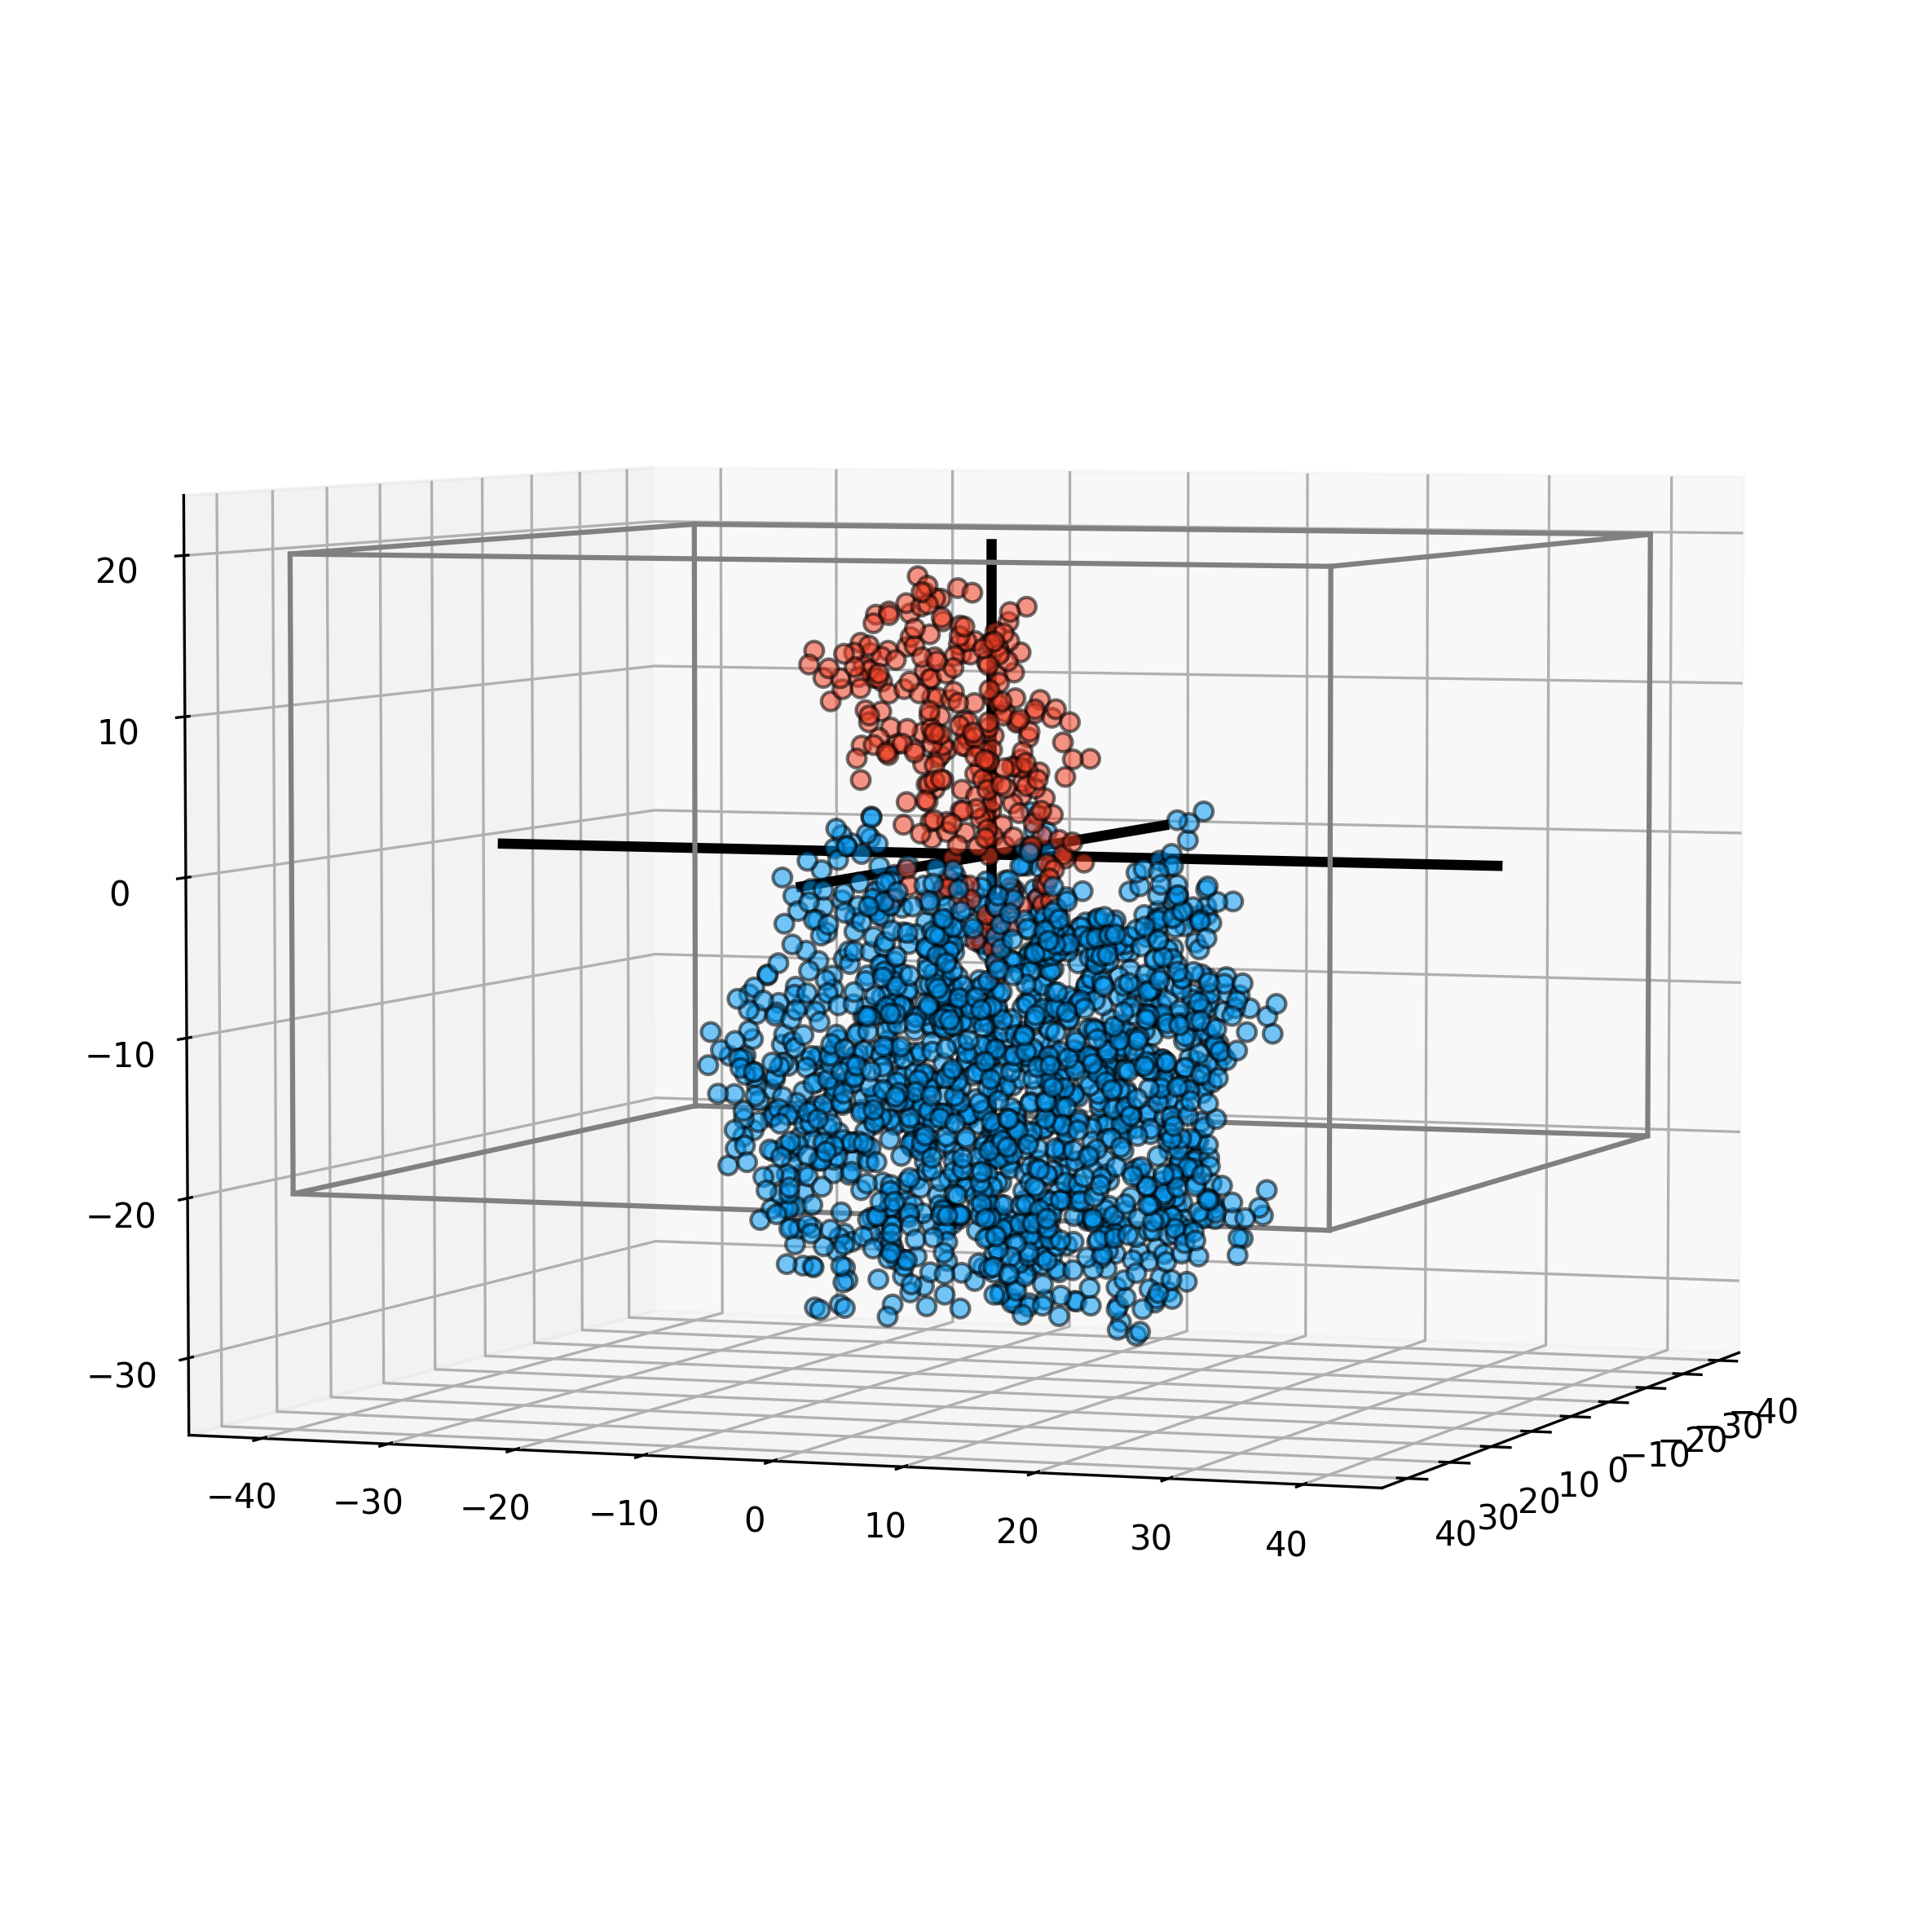

In [ ]:

Atoms_coord = Atoms_coord_df.copy()
Atoms_coord['x'] = Atoms_coord['x']-dot_is[0]
Atoms_coord['y'] = Atoms_coord['y']-dot_is[1]
Atoms_coord['z'] = Atoms_coord['z']-dot_is[2]

from_bazis = np.concatenate((np.expand_dims(proj_vec, axis=1),
                             np.expand_dims(last_vector, axis=1),
                             np.expand_dims(norm, axis=1)
                            ), axis=1)
to_bazis = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
s = np.matmul(np.linalg.inv(from_bazis), to_bazis)
x_new = []
y_new = []
z_new = []
for i, item in Atoms_coord.iterrows():
    vec = np.array([[item['x']], [item['y']], [item['z']]])
    new_vec = np.matmul(s, vec)
    new_xy = rotate_point_wrt_center(point_to_be_rotated = (new_vec[0][0], new_vec[1][0]), angle = 0, center_point = (0, 0))
    x_new.append(new_xy[0])
    y_new.append(new_xy[1])
    z_new.append(new_vec[2][0])
Atoms_coord['x_new'] = x_new
Atoms_coord['y_new'] = y_new
Atoms_coord['z_new'] = z_new

high_gr = 20
length_gr = 40
width_gr = 40
high_v = [[0, 0, -high_gr], [0, 0, high_gr]]
length_v = [[-length_gr, 0, 0], [length_gr, 0, 0]]
width_v = [[0, -width_gr, 0], [0, width_gr, 0]]


fig = plt.figure(figsize=(16, 10), dpi=300)
ax = plt.axes(projection="3d")
ax.plot3D([high_v[0][0],high_v[1][0]], [high_v[0][1],high_v[1][1]], [high_v[0][2],high_v[1][2]], 'black', linewidth= 3)
ax.plot3D([length_v[0][0],length_v[1][0]], [length_v[0][1],length_v[1][1]], [length_v[0][2],length_v[1][2]], 'black', linewidth= 3)
ax.plot3D([width_v[0][0],width_v[1][0]], [width_v[0][1],width_v[1][1]], [width_v[0][2],width_v[1][2]], 'black', linewidth= 3)

chain_list = list(map(int, Atoms_coord['Chain_num'].values))
colors = np.array(["#069AF3", "#EF4026"])
ax.scatter3D(Atoms_coord['x_new'], Atoms_coord['y_new'], Atoms_coord['z_new'], c=colors[chain_list], edgecolors='black', s=30, alpha=0.55)
plot_linear_cube(-length_gr, -width_gr, -high_gr, length_gr*2, width_gr*2, high_gr*2, color='gray')

ax.view_init(4, 20)
fig.savefig('Cell.png', bbox_inches = 'tight')

In [ ]:
Atoms_coord

Chain_name  Chain_num Residue Type          x          y         z  \
0             E          0     ILE    N   8.524753   6.380974  6.948234   
1             E          0     ILE   CA   9.037753   7.742974  6.626234   
2             E          0     ILE    C  10.383753   7.574974  5.913234   
3             E          0     ILE    O  11.275753   6.911974  6.440234   
4             E          0     ILE   CB   9.263753   8.593974  7.906234   
...         ...        ...     ...  ...        ...        ...       ...   
1910          I          1     PRO    C   5.974753 -18.812026  4.142234   
1911          I          1     PRO    O   6.072753 -18.997026  2.904234   
1912          I          1     PRO   CB   3.612753 -19.035026  5.059234   
1913          I          1     PRO   CG   2.836753 -19.171026  3.763234   
1914          I          1     PRO   CD   2.784753 -17.744026  3.275234   

          x_new      y_new      z_new  
0      0.129506  -8.074930  -9.820638  
1     -0.991596  -8.260466 -10.785316  
2     -1.788658  -9.490817 -10.338955  
3     -1.211322 -10.563081 -10.166053  
4     -0.477018  -8.507321 -12.230289  
...         ...        ...        ...  
1910  12.189059 -10.053991  12.533643  
1911  11.269840  -9.998754  13.387141  
1912  13.600682  -7.944875  12.364484  
1913  12.812149  -7.024068  13.275867  
1914  11.653875  -6.624298  12.395094  

[1915 rows x 10 columns]

## Selection of atoms involved in bonding

In [ ]:
Cell_atoms = pd.DataFrame(columns=['Chain_name', 'Chain_num', 'Residue', 'Type', 'Atom_id', 'x_new', 'y_new', 'z_new'])
for id_atom in range(Atoms_coord.shape[0]):
    at_coord = Atoms_coord.iloc[id_atom]
    if abs(at_coord['x_new'])<= length_gr and abs(at_coord['y_new'])<= width_gr and abs(at_coord['z_new'])<= high_gr:
        x_ind = at_coord['x_new']+length_gr
        y_ind = at_coord['y_new']+width_gr
        z_ind = at_coord['z_new']+high_gr
        Cell_atoms.loc[len(Cell_atoms.index)] = [at_coord['Chain_name'], at_coord['Chain_num'], at_coord['Residue'], at_coord['Type'], id_atom+1, x_ind, y_ind, z_ind]
if Cell_atoms.shape[0] < 10:
    with open("Dataset/Diff_struct_new.csv", mode="a", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter = ",")
        file_writer.writerow([str_num, struct_id])

In [ ]:
Cell_atoms

Chain_name  Chain_num Residue Type  Atom_id      x_new      y_new  \
0             E          0     ILE    N        1  40.129506  31.925070   
1             E          0     ILE   CA        2  39.008404  31.739534   
2             E          0     ILE    C        3  38.211342  30.509183   
3             E          0     ILE    O        4  38.788678  29.436919   
4             E          0     ILE   CB        5  39.522982  31.492679   
...         ...        ...     ...  ...      ...        ...        ...   
1511          I          1     PRO    C     1911  52.189059  29.946009   
1512          I          1     PRO    O     1912  51.269840  30.001246   
1513          I          1     PRO   CB     1913  53.600682  32.055125   
1514          I          1     PRO   CG     1914  52.812149  32.975932   
1515          I          1     PRO   CD     1915  51.653875  33.375702   

          z_new  
0     10.179362  
1      9.214684  
2      9.661045  
3      9.833947  
4      7.769711  
...         ...  
1511  32.533643  
1512  33.387141  
1513  32.364484  
1514  33.275867  
1515  32.395094  

[1516 rows x 8 columns]

Creating a table of atoms with a distance to another chain of less than 10 Angstroms

In [ ]:
Cell_atoms_10 = pd.DataFrame(columns=[ 'Index', 'Chain_name', 'Chain_num', 'Residue', 'Type', 'Atom_id', 'x_new', 'y_new', 'z_new'])
atoms_chain1 = Cell_atoms[Cell_atoms['Chain_num'] == 0]
atoms_chain2 = Cell_atoms[Cell_atoms['Chain_num'] == 1]
for i in atoms_chain1.index.values:
    atom1 = atoms_chain1.loc[i]
    for j in atoms_chain2.index.values:
        atom2 = atoms_chain2.loc[j]
        b = [atom1['x_new']-atom2['x_new'], atom1['y_new']-atom2['y_new'], atom1['z_new']-atom2['z_new']]
        b_norm = np.linalg.norm(b)
        if b_norm <= 10:
            if i not in Cell_atoms_10['Index'].values:
                Cell_atoms_10.loc[len(Cell_atoms_10.index)] = [i, atom1['Chain_name'], atom1['Chain_num'], atom1['Residue'], atom1['Type'], atom1['Atom_id'], atom1['x_new'], atom1['y_new'], atom1['z_new']]
            if j not in Cell_atoms_10['Index'].values:
                Cell_atoms_10.loc[len(Cell_atoms_10.index)] = [j, atom2['Chain_name'], atom2['Chain_num'], atom2['Residue'], atom2['Type'], atom2['Atom_id'], atom2['x_new'], atom2['y_new'], atom2['z_new']]
            continue

In [ ]:
Cell_atoms_10

Index Chain_name  Chain_num Residue Type  Atom_id      x_new      y_new  \
0        83          A          0     ASP    O       88  25.111622  46.140770   
1      2515          B          1     ARG  NH2     2888  26.292169  40.160073   
2        85          A          0     ASP   CG       90  22.395808  48.892172   
3      2339          B          1     LEU  CD1     2686  22.612862  42.054978   
4        86          A          0     ASP  OD1       91  23.112244  49.491772   
...     ...        ...        ...     ...  ...      ...        ...        ...   
1105   1277          A          0     PHE   CG     1461  19.759079  54.805993   
1106   1278          A          0     PHE  CD1     1462  18.887486  54.343097   
1107   1279          A          0     PHE  CD2     1463  20.689244  55.793701   
1108   1281          A          0     PHE  CE2     1465  20.752270  56.312180   
1109   1282          A          0     PHE   CZ     1466  19.873689  55.843402   

          z_new  
0      8.459672  
1     15.557036  
2     10.246031  
3     17.271394  
4     11.074724  
...         ...  
1105  23.097048  
1106  22.113222  
1107  22.765397  
1108  21.473585  
1109  20.491360  

[1110 rows x 9 columns]

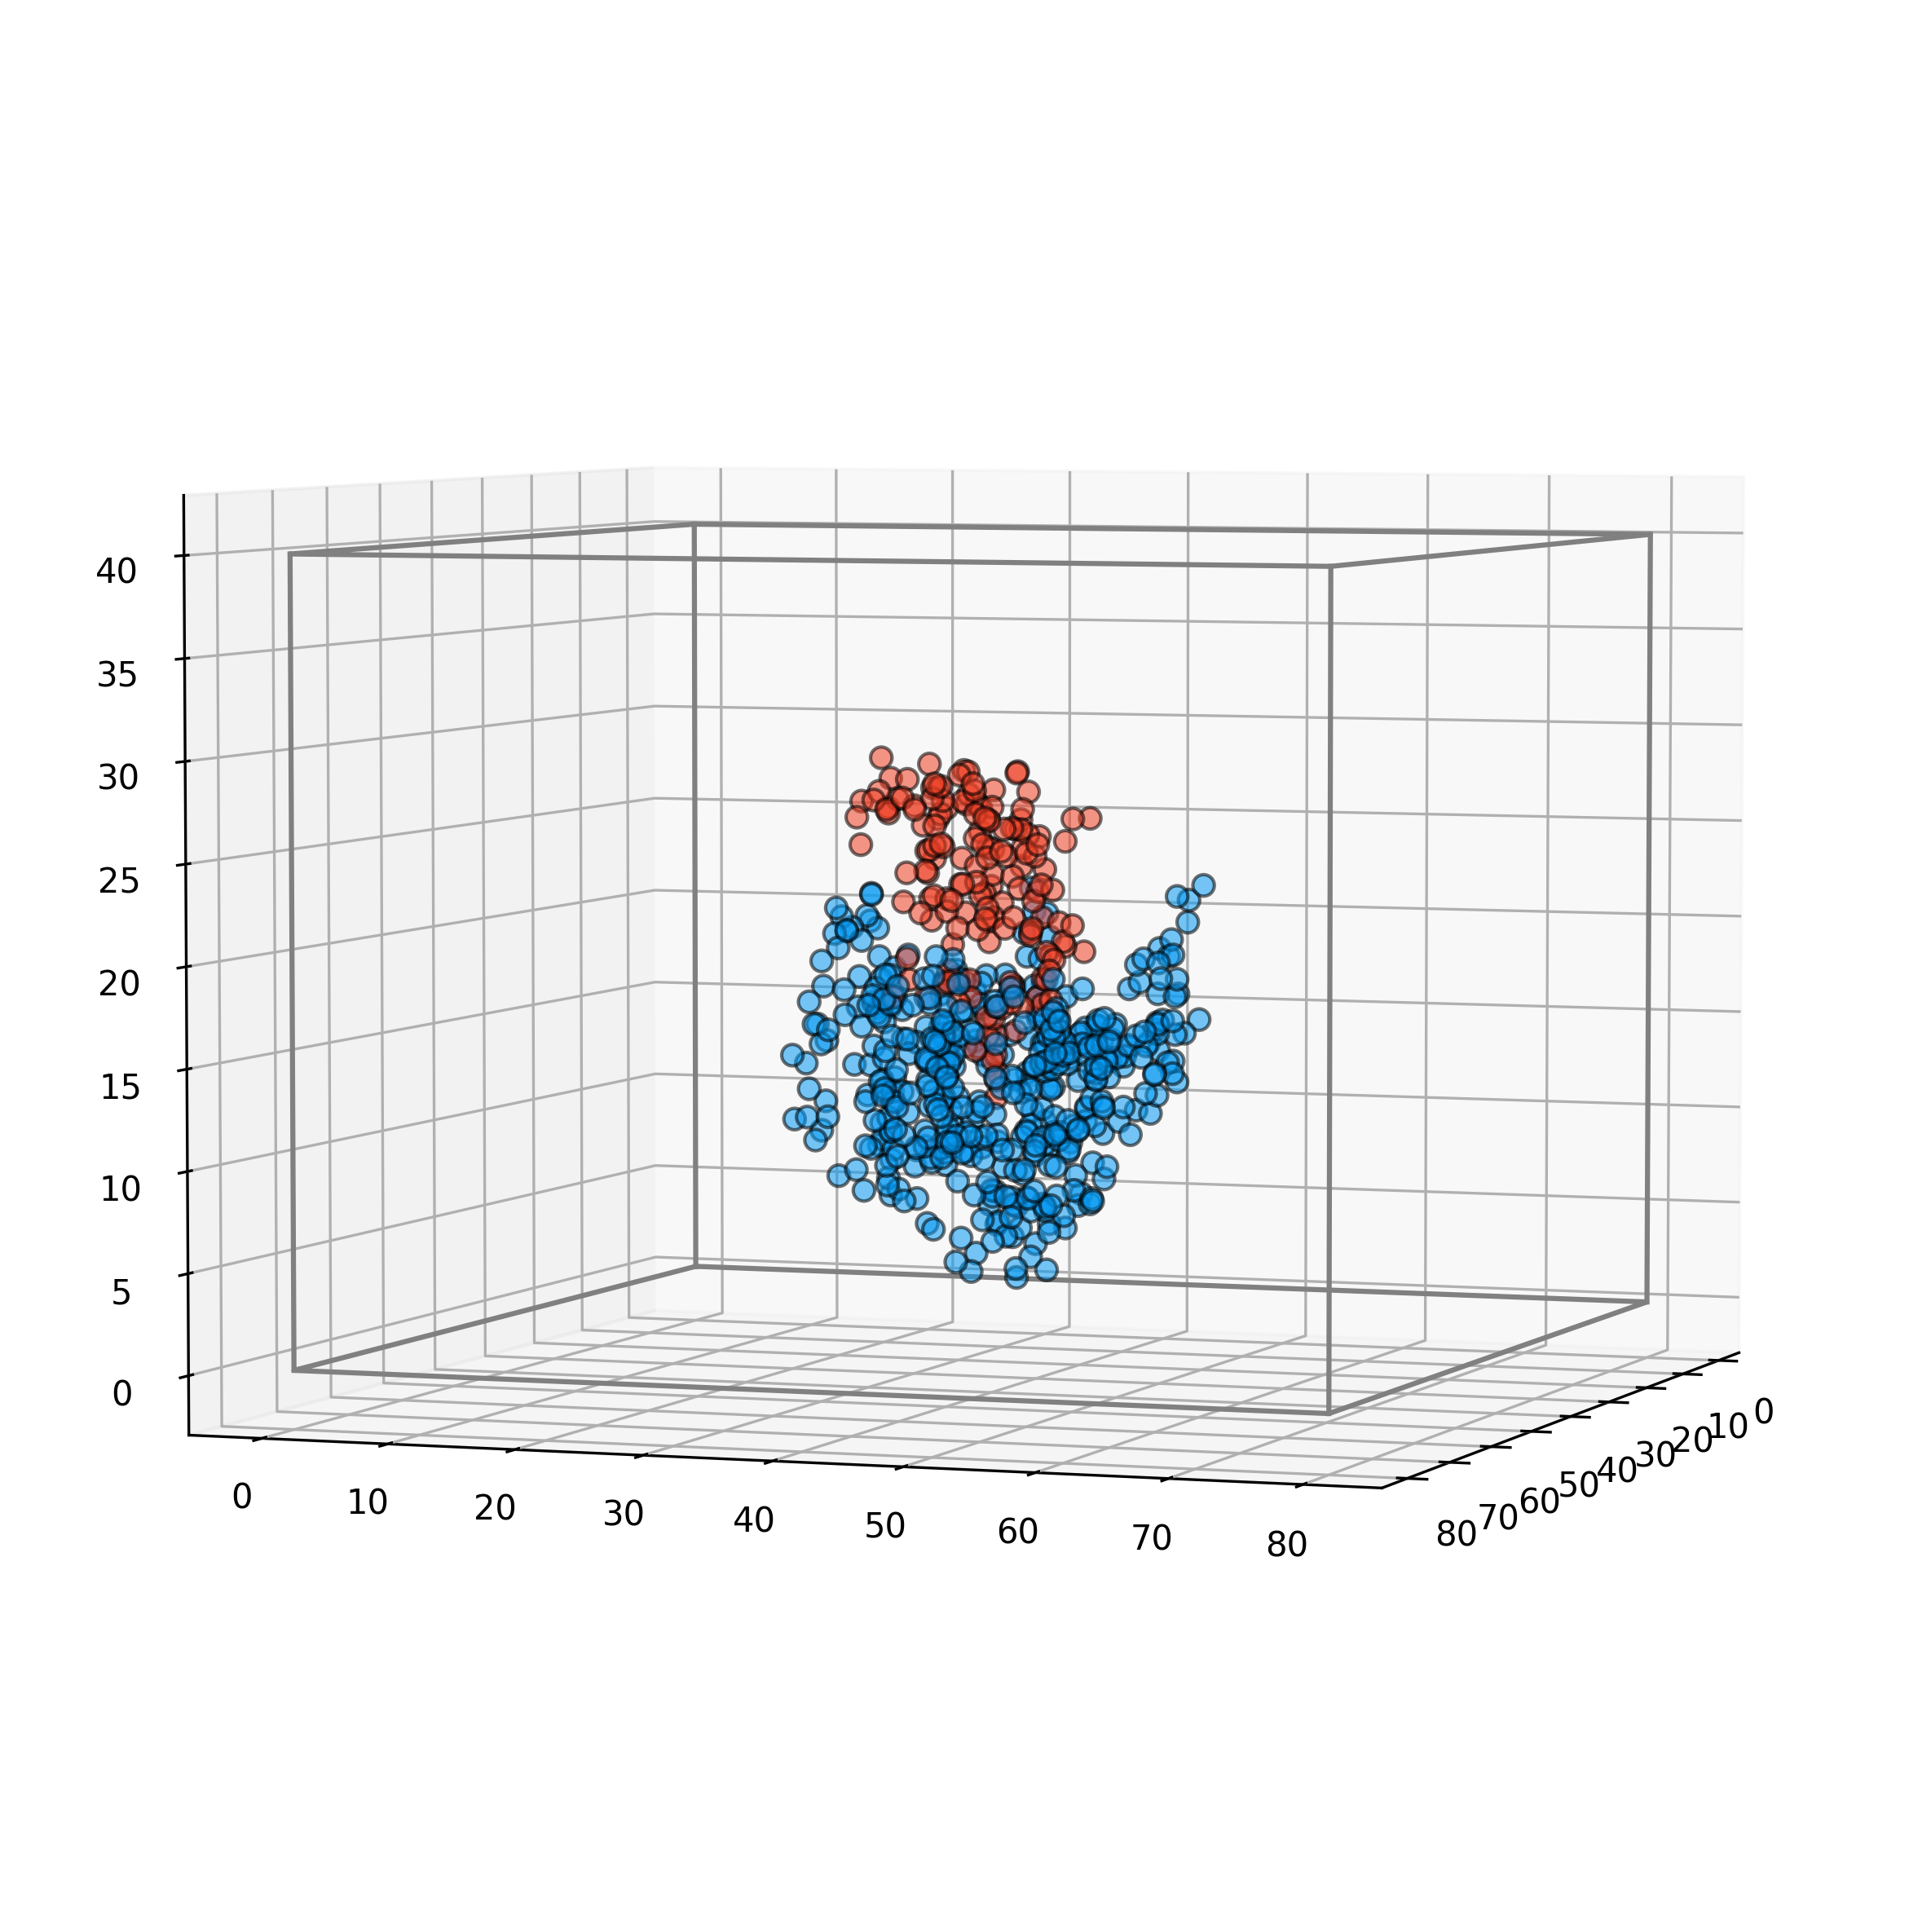

In [ ]:

fig = plt.figure(figsize=(16, 10), dpi=300)
ax = plt.axes(projection="3d")

chain_list = list(map(int, Cell_atoms_10['Chain_num'].values))
colors = np.array(["#069AF3", "#EF4026"])
ax.scatter3D(Cell_atoms_10['x_new'], Cell_atoms_10['y_new'], Cell_atoms_10['z_new'], c=colors[chain_list], edgecolors='black', s=40, alpha=0.55)
plot_linear_cube(0, 0, 0, length_gr*2, width_gr*2, high_gr*2, color='gray')

ax.view_init(4, 20)
fig.savefig('Result_cell.png', bbox_inches = 'tight')